### 📚 Bayesian Sequential Update for Linear Regression — Step-by-Step Explanation

We use Bayesian linear regression to learn a distribution over model parameters instead of a single best-fit solution. This allows us to represent **uncertainty** in our predictions and update our beliefs as new data arrives **sequentially**.

---

### 🧠 What We're Doing

We model the target as:
\[
t_n = \phi(x_n)^\top \mathbf{w} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
\]

Instead of solving for a single weight vector \( \mathbf{w} \), we maintain a **posterior distribution** over weights that gets updated with every new data point.

---

### 🔧 Step-by-Step Breakdown

#### 🟩 1. Prior over weights

We begin with a Gaussian prior:
\[
p(\mathbf{w}) = \mathcal{N}(\mathbf{w} \mid \mathbf{m}_0, \mathbf{S}_0)
\]

Typically:
- \( \mathbf{m}_0 = \mathbf{0} \)
- \( \mathbf{S}_0 = \mathbf{I} \)

This represents our **initial belief**: weights are independent with unit variance.

---

#### 🟩 2. Likelihood from a single data point

Given one data point \( (x_n, t_n) \), the likelihood is:
\[
p(t_n \mid \mathbf{w}) = \mathcal{N}(t_n \mid \phi(x_n)^\top \mathbf{w}, \sigma^2)
\]

This models how likely the observed output is for a given weight vector \( \mathbf{w} \).

---

#### 🟩 3. Bayes’ Rule for Posterior

Using Bayes' rule, we update our belief:
\[
p(\mathbf{w} \mid \mathcal{D}_n) \propto p(\mathbf{w}) \cdot \prod_{i=1}^n p(t_i \mid \mathbf{w})
\]

Instead of recomputing from scratch, we **sequentially update**:
- \( \mathbf{m}_n \): posterior mean of weights
- \( \mathbf{S}_n \): posterior covariance

---

### ✅ Posterior Update Equations

After observing \( n \) data points, we update the posterior:

\[
\mathbf{S}_n^{-1} = \mathbf{S}_{n-1}^{-1} + \frac{1}{\sigma^2} \phi(x_n)\phi(x_n)^\top
\]

\[
\mathbf{m}_n = \mathbf{S}_n \left( \mathbf{S}_{n-1}^{-1} \mathbf{m}_


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# True function
def true_func(x):
    return np.sin(2 * np.pi * x)

# Generate 100 points uniformly in [0, 1]
x = np.linspace(0, 1, 100)
x = x.reshape(-1,1)
t = (true_func(x) + np.random.normal(0, 0.1, size=x.shape)).flatten() # noise std = 0.1


In [8]:
def gaussian_basis_function(x, mu, s_param):
    return np.exp(-0.5 * ((x - mu) / s_param) ** 2)

# Choose 20 basis functions with centers evenly spaced in [0,1]
M = 20
centers = np.linspace(0, 1, M)
centers = centers.reshape(1,-1)
sigma = 0.05  # width of each Gaussian
Phi = gaussian_basis_function(x, centers, sigma)


In [9]:
######################################
# Functions for Fitting and Prediction
######################################

def fit_regularized_least_squares(phi_matrix, t_vector, lambda_reg):
    M_params = phi_matrix.shape[1]
    identity_matrix = np.identity(M_params)
    A = phi_matrix.T @ phi_matrix + lambda_reg * identity_matrix
    b = phi_matrix.T @ t_vector
    try:
        weights = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print(
            f"Warning: Singular matrix encountered with lambda={lambda_reg}.\n"
            f"Using pseudo-inverse."
        )
        weights = np.linalg.pinv(A) @ b
    return weights

def predict(phi_matrix, weights):
    return phi_matrix @ weights

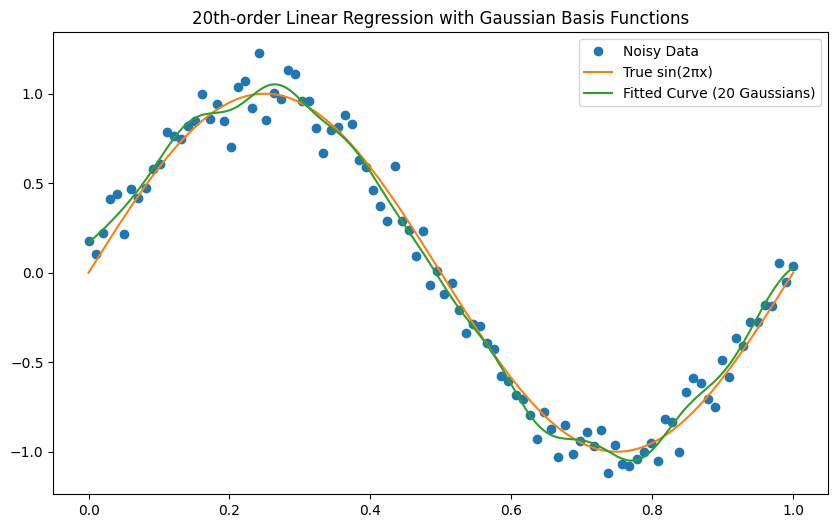

In [10]:
# Predict
lamda = 0.01
x_test = np.linspace(0, 1, 1000)
x_test = x_test.reshape(-1,1)
w = fit_regularized_least_squares(Phi,t,lamda)
Phi_test = gaussian_basis_function(x_test, centers, sigma)
y_pred = Phi_test @ w

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, t, 'o', label='Noisy Data')
plt.plot(x_test, true_func(x_test), label='True sin(2πx)')
plt.plot(x_test, y_pred, label='Fitted Curve (20 Gaussians)')
plt.legend()
plt.title('20th-order Linear Regression with Gaussian Basis Functions')
plt.show()


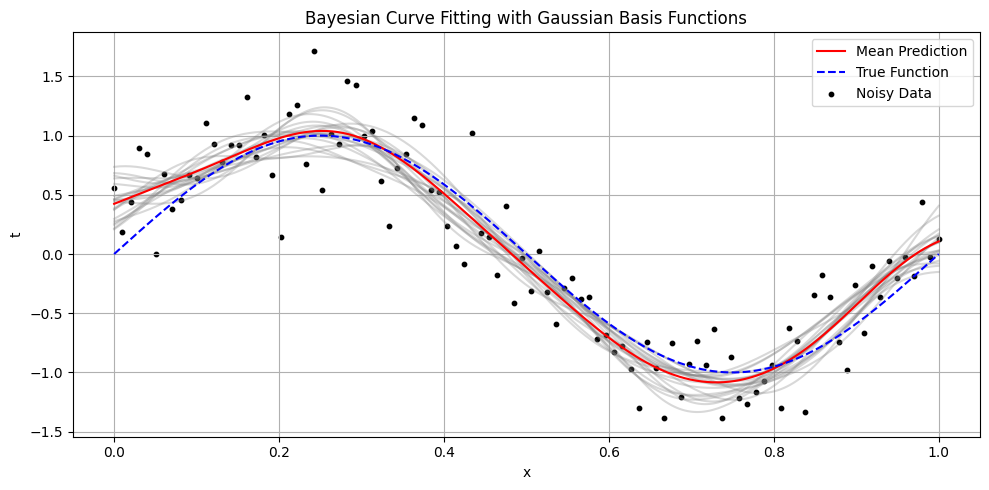

In [8]:
def bayesian_update(prior_mean, prior_cov, phi_x, t_val, sigma2):
    """
    Update the posterior mean and covariance with a new (phi_x, t_val) pair.
    """
    phi_x = phi_x.reshape(-1, 1)  # Ensure column vector
    S_inv = np.linalg.inv(prior_cov)
    
    # Update posterior covariance
    S_new_inv = S_inv + (1 / sigma2) * (phi_x @ phi_x.T)
    S_new = np.linalg.inv(S_new_inv)
    
    # Update posterior mean
    m_new = S_new @ (S_inv @ prior_mean + (1 / sigma2) * phi_x.flatten() * t_val)
    
    return m_new, S_new


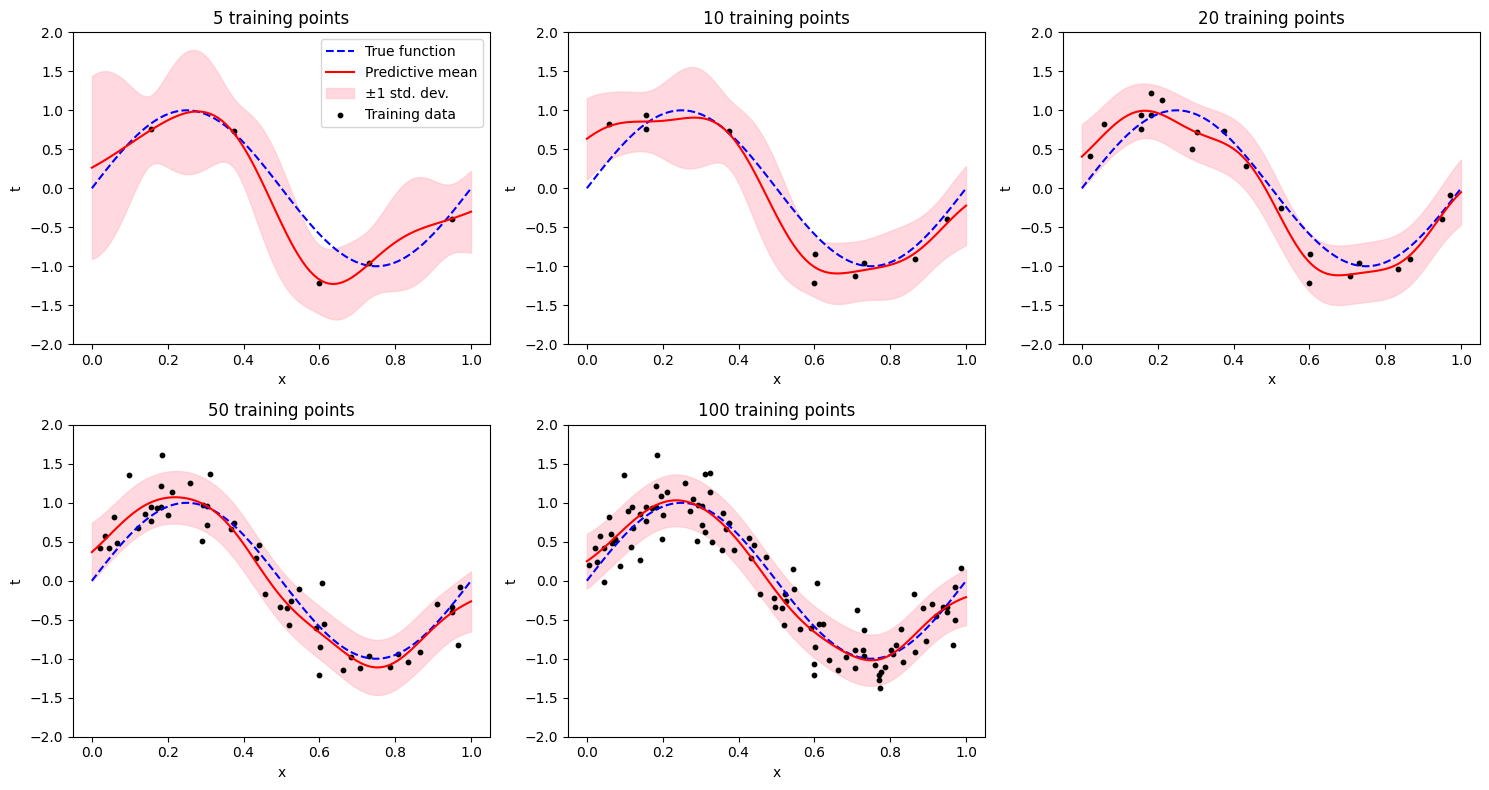

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Basis function: Gaussian RBFs
def gaussian_design_matrix(x, centers, sigma):
    return np.exp(-0.5 * ((x[:, None] - centers[None, :]) / sigma) ** 2)

# True underlying function
def true_function(x):
    return np.sin(2 * np.pi * x)

# Prior and noise precision
alpha = 1.0  # prior precision
noise_var = 0.1
beta = 1.0 / noise_var  # noise precision

M = 20  # number of basis functions
sigma = 0.1  # Gaussian width

# Predictive input points
x0 = np.linspace(0, 1, 100).reshape(-1, 1)

# Generate dataset
np.random.seed(42)
x_all = np.random.uniform(0, 1, 100)
t_all = true_function(x_all) + np.random.normal(0, np.sqrt(noise_var), size=x_all.shape)

centers = np.linspace(0, 1, M)
Phi0 = gaussian_design_matrix(x0.ravel(), centers, sigma)

training_sizes = [5, 10, 20, 50, 100]
plt.figure(figsize=(15, 8))

for i, N in enumerate(training_sizes):
    x_train = x_all[:N]
    t_train = t_all[:N]
    Phi = gaussian_design_matrix(x_train, centers, sigma)
    
    # Posterior covariance and mean
    S_N_inv = alpha * np.eye(M) + beta * Phi.T @ Phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ Phi.T @ t_train

    # Predictive mean
    mean_pred = Phi0 @ m_N

    # Predictive variance
    var_pred = 1 / beta + np.sum(Phi0 @ S_N * Phi0, axis=1)
    var_pred = np.clip(var_pred, 1e-10, None)  # Avoid sqrt of negative

    # Plot
    plt.subplot(2, 3, i+1)
    plt.title(f'{N} training points')
    plt.plot(x0, true_function(x0), 'b--', label='True function')
    plt.plot(x0, mean_pred, 'r', label='Predictive mean')
    plt.fill_between(x0.ravel(),
                     mean_pred - np.sqrt(var_pred),
                     mean_pred + np.sqrt(var_pred),
                     color='pink', alpha=0.6, label='±1 std. dev.')
    plt.scatter(x_train, t_train, color='black', s=10, label='Training data')
    plt.ylim(-2, 2)
    plt.xlabel('x')
    plt.ylabel('t')

    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()
